In [1]:
import sys
sys.path.append('..')

import geopandas as gdp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

import arviz as az
import pymc as pm
import pytensor.tensor as pt
from scipy import sparse
from scipy.linalg import solve
from scipy.sparse.linalg import spsolve

from laos_gggi.shapefiles_data_loader import load_shapefile
from laos_gggi.GPCC_data_loader import download_gpcc_data
from laos_gggi.emdat_processing import process_emdat
from laos_gggi.const_vars import COUNTRIES_ISO, ISO_DICTIONARY

from libpysal.weights import Queen, KNN, fuzzy_contiguity, w_union, W
from esda.moran import Moran
import networkx as nx
import warnings
from itertools import zip_longest

# Load Data

In [2]:
precip_df = download_gpcc_data(repair_ISO_codes=True)
world = load_shapefile('world', repair_ISO_codes=True)
laos = load_shapefile('laos')
data = process_emdat()

df_prob = data["df_prob_filtered_adjusted"].drop(['Region', "Subregion"], axis=1)
df_inten = data["df_inten_filtered_adjusted"].drop(['Region'], axis=1)

df_prob = (df_prob.reset_index()
     .assign(**{'Start_Year': lambda x: pd.to_datetime(x['Start_Year'], format='%Y')})
     .set_index(['ISO', 'Start_Year']))

## Reconsile EMDAT and shapefile ISO codes


In [3]:
world.set_index('ISO_A3', inplace=True)

In [4]:
emdat_iso = df_prob.index.get_level_values(0).unique()
world_iso = world.index.unique()

In [5]:
# Codes in EMDAT but not in world
# These are all historical:
", ".join(list(set(emdat_iso) - set(world_iso)))

'YUG, SCG, SPI, REU, TKL, GUF, ANT, AZO, DFR, GLP, YMN, MTQ, SUN, YMD, TWN'

From ChatGPT -- Check

- ANT - Netherlands Antilles (dissolved in 2010)
- YUG - Yugoslavia (dissolved in the early 1990s)
- DFR - German Democratic Republic (East Germany, merged with West Germany in 1990)
- CSK - Czechoslovakia (split into Czech Republic and Slovakia in 1993)
- DDR - German Democratic Republic (East Germany, same as DFR)
- SPI - Spain
- YMD - Yemen Democratic Republic (South Yemen, unified with North Yemen in 1990)
- TWN - Taiwan (Republic of China)
- SCG - Serbia and Montenegro (dissolved in 2006)
- MTQ - Martinique
- SUN - Soviet Union (dissolved in 1991)
- GUF - French Guiana
- REU - Réunion
- TKL - Tokelau
- YMN - Yemen (Republic of Yemen)
- AZO - Azores (part of Portugal)
- GLP - Guadeloupe

In [6]:
# Codes in shapefile but not in EMDAT
", ".join(list(set(world_iso) - set(emdat_iso)))

'BRN, FRO, NFK, BHR, AND, UNK, BMU, VAT, GNQ, PCN, GIB, MAF, FIN, BLM, LVA, IMN, IOT, ARE, MNP, GGY, GRL, LIE, TCA, FLK, TKM, VGB, NIU, EST, CUW, ATF, SMR, SGP, JEY, KWT, CYM, SHN, MCO, NRU, SGS, ABW, SPM, HMD, MLT, DNK'

From ChatGPT -- Check

- PCN - Pitcairn Islands
- NFK - Norfolk Island
- HMD - Heard Island and McDonald Islands
- ATF - French Southern and Antarctic Lands
- GGY - Guernsey
- AND - Andorra
- BHR - Bahrain
- VAT - Vatican City (Holy See)
- SPM - Saint Pierre and Miquelon
- FRO - Faroe Islands
- NRU - Nauru
- GRL - Greenland
- IOT - British Indian Ocean Territory
- JEY - Jersey
- FLK - Falkland Islands
- UNK - United Nations (used for various purposes)
- MCO - Monaco
- LIE - Liechtenstein
- SGP - Singapore
- CUW - Curaçao
- SMR - San Marino
- GNQ - Equatorial Guinea
- ABW - Aruba
- GIB - Gibraltar
- SGS - South Georgia and the South Sandwich Islands

## Drop codes not in both

In [7]:
common_codes = set(world_iso).intersection(set(emdat_iso))
df_prob = df_prob.loc[lambda x: x.index.get_level_values(0).isin(common_codes)].copy()
df_inten = df_inten.loc[lambda x: x.index.get_level_values(0).isin(common_codes)].copy()
world = world.loc[world.index.isin(common_codes)].copy()

## Get unique iso codes and years

In [8]:
code_idx, codes = pd.factorize(df_prob.index.get_level_values(0), sort=True)
year_idx, years = pd.factorize(df_prob.index.get_level_values(1), sort=True)
disasters = df_prob.columns.tolist()

In [9]:
df_prob.columns.tolist()

['Drought',
 'Earthquake',
 'Extreme temperature',
 'Flood',
 'Storm',
 'Volcanic activity',
 'Wildfire']

# Maps

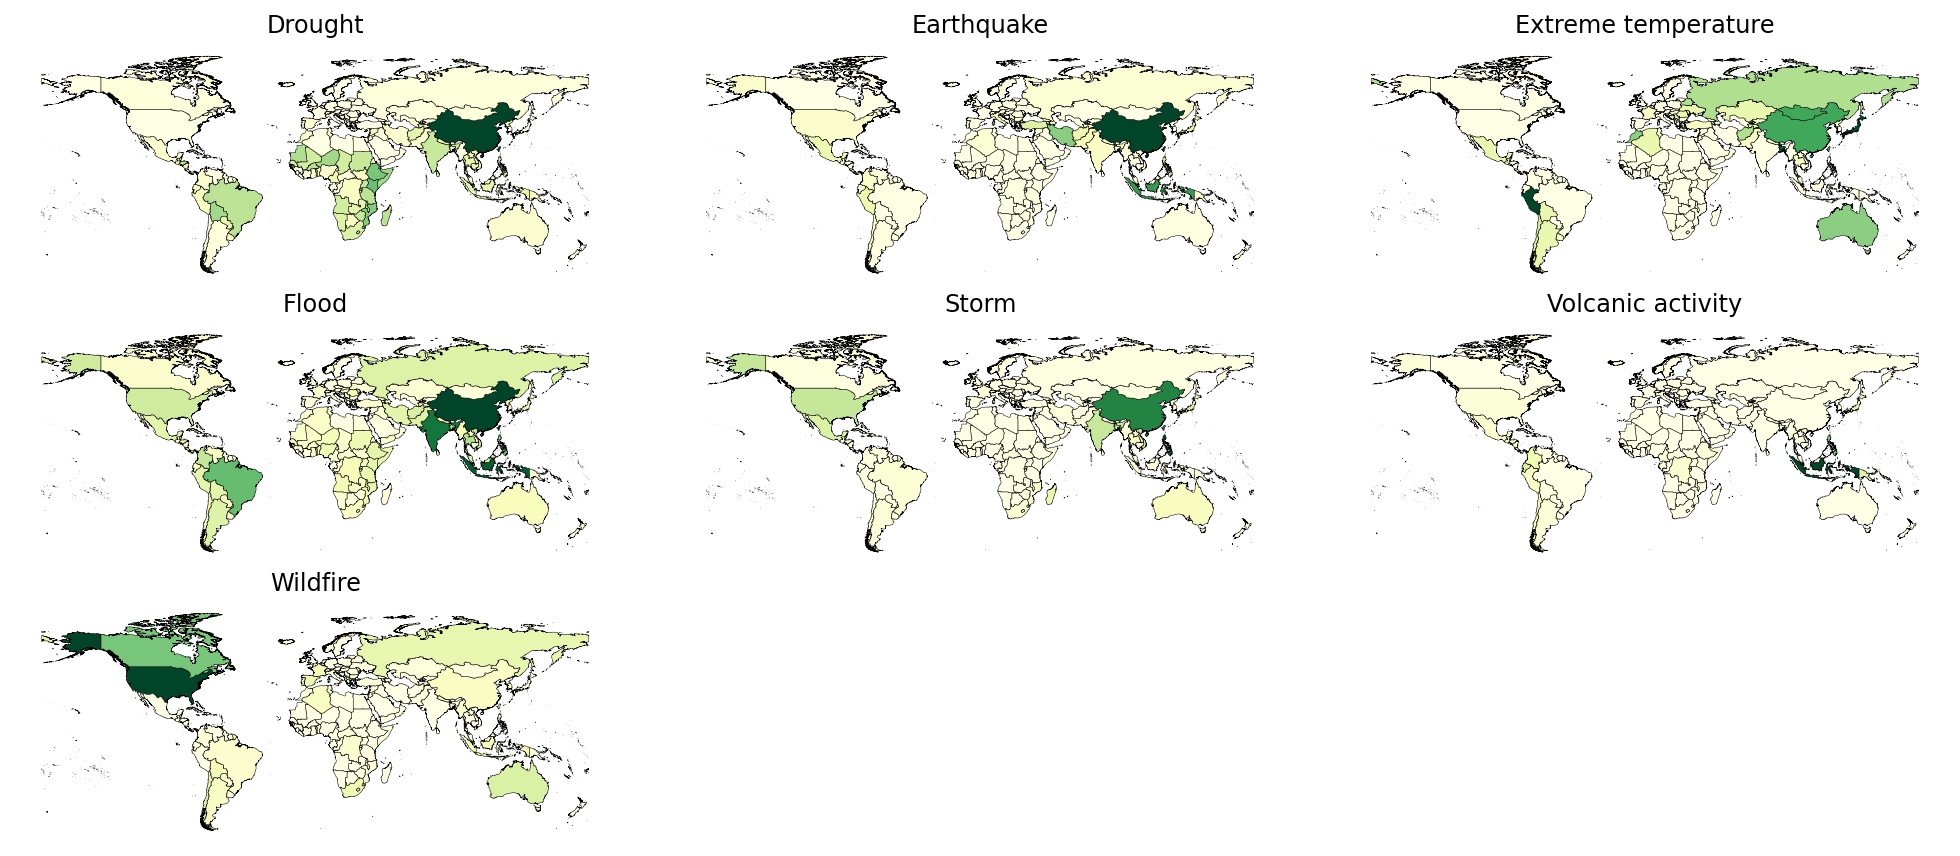

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(14, 6), dpi=144)
for axis, disaster in zip_longest(fig.axes, disasters):    
    if disaster is None:
        axis.set_visible(False)
        continue
        
    disaster_2000s = df_prob.loc['2000':, [disaster]].groupby(level=0).sum()
    disaster_2000s = (disaster_2000s - disaster_2000s.mean()) / disaster_2000s.std()
    pd.merge(world, disaster_2000s, left_index=True, right_index=True).plot(disaster, ax=axis, cmap='YlGn', edgecolor='k', lw=0.25)
    axis.set_title(disaster)
    axis.axis('off')
fig.tight_layout()
plt.show()

# Networks

In [11]:
with warnings.catch_warnings(action='ignore'):
    # Make graph of bordering countires
    w1 = fuzzy_contiguity(world)
    
    # Robustness of statistics to choice of k?
    w2 = KNN.from_dataframe(world, k=2)    
    w = w_union(w1, w2)
    keys = sorted(list(w.neighbors.keys()))
    
    G = w.to_networkx().to_undirected()
    
    # Discard all but the main connected component (largest connected subgraph)
    G = nx.subgraph(G, list(nx.connected_components(G))[0])
    
    # Make a dataset of only the regions in the resulting graph
    connected_world = world.iloc[list(G.nodes)].copy()
    idx_to_name = dict(enumerate(keys))
    
    # Change node names from numbers to ISO codes and do a sanity check
    G = nx.relabel_nodes(G, idx_to_name)
    assert list(G['USA'].keys()) == ['CAN', 'MEX']
    
    
    # Compute the weight matrix resulting from the graph and do a sanity check
    w = W.from_networkx(G)
    w.remap_ids(list(G.nodes))
    assert w.neighbors['USA'] == ['CAN', 'MEX']

In [12]:
#Creating the adjacency matrix
A = nx.adjacency_matrix(G)

In [13]:
# Compute node positions for network graph (spring layout)
pos = nx.drawing.nx_pydot.graphviz_layout(G, 'neato')

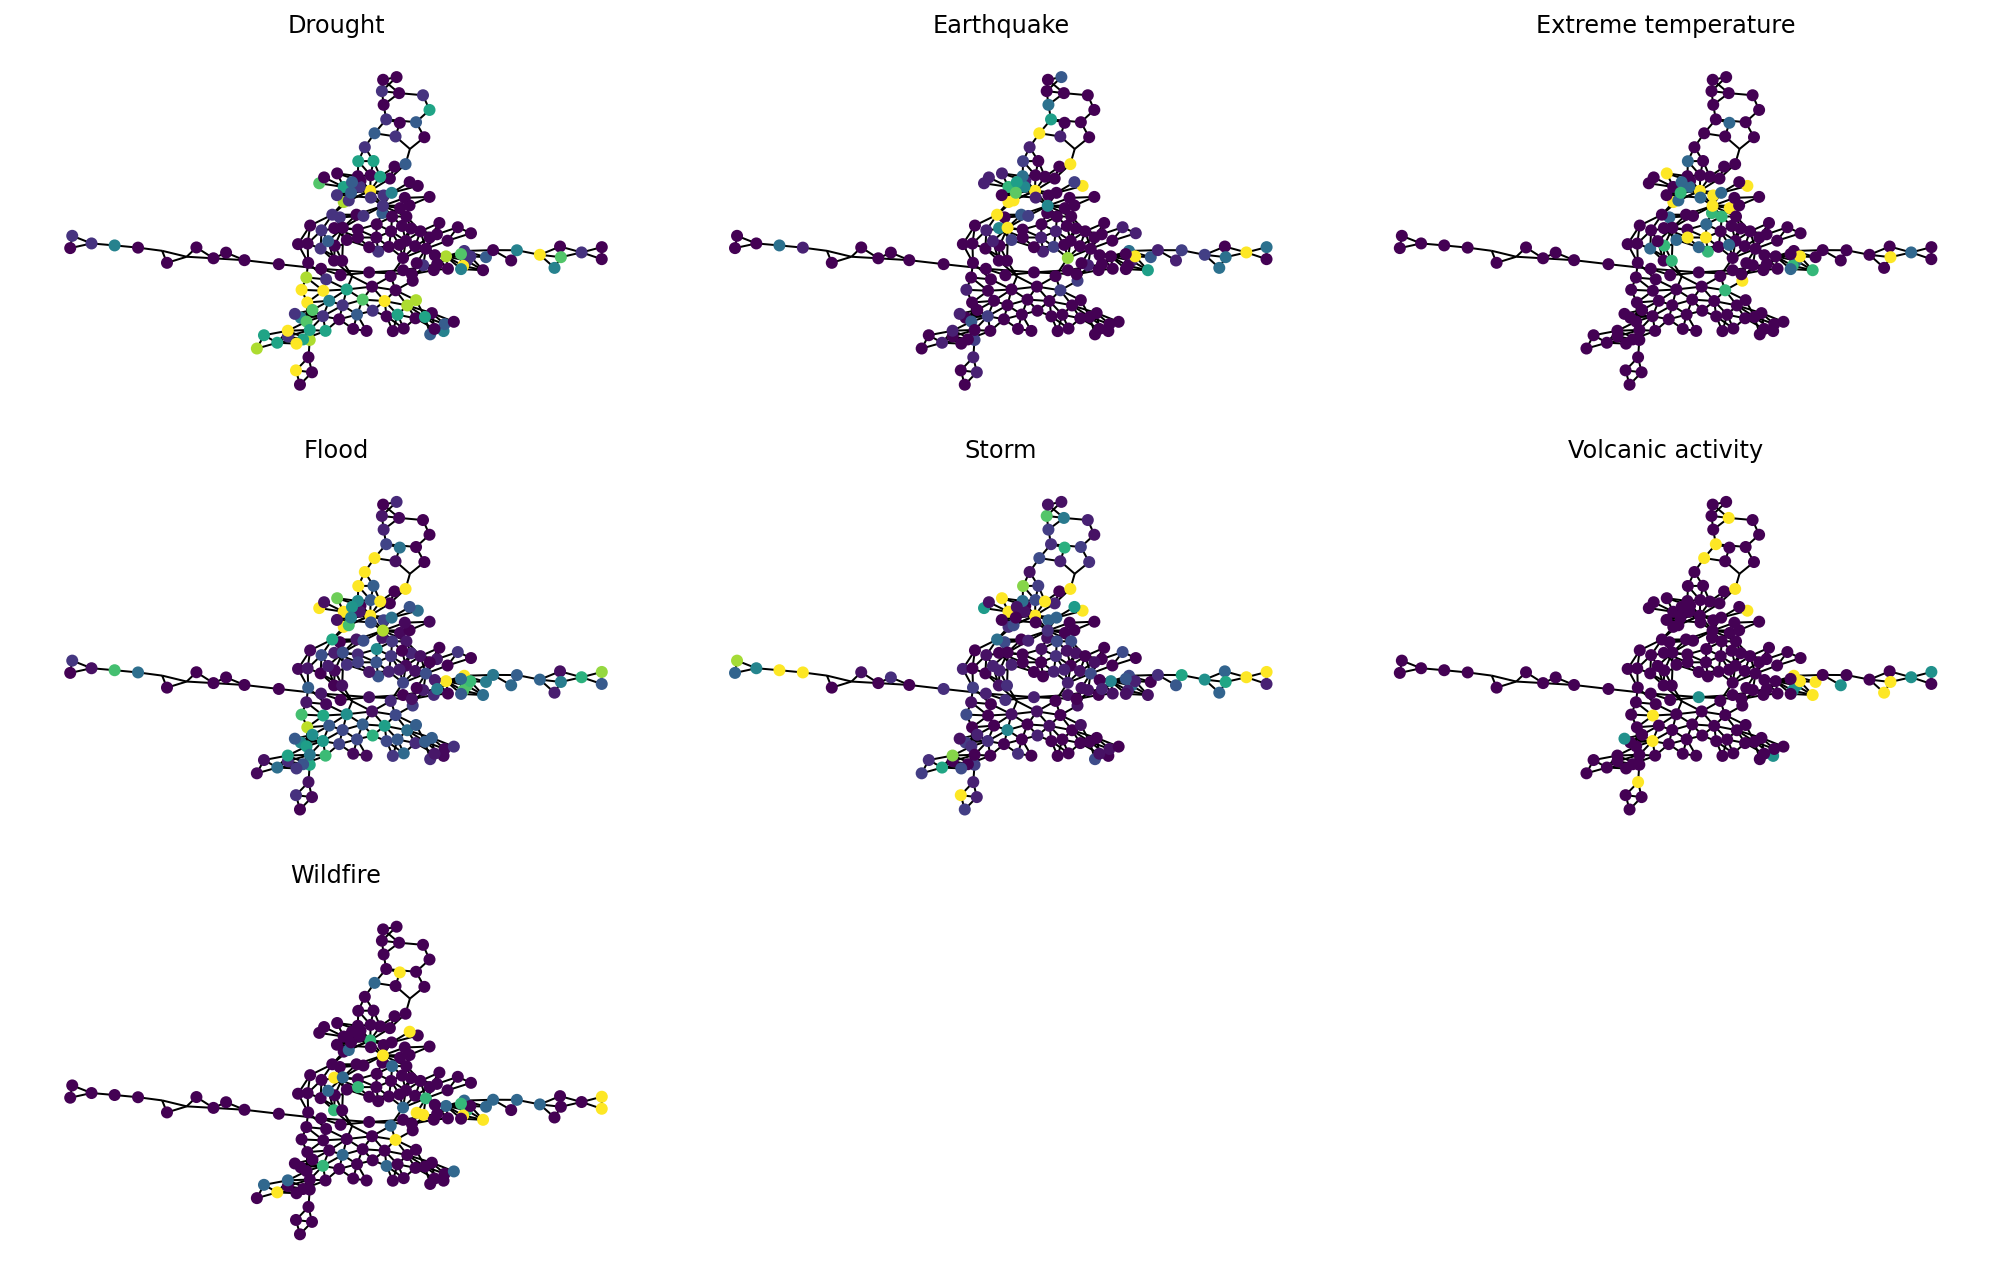

In [14]:
fig, ax = plt.subplots(3, 3, figsize=(14, 9), dpi=144)

for axis, disaster in zip_longest(fig.axes, df_prob):
    if disaster is None:
        axis.set_visible(False)
        continue
    
    merged_df = connected_world.join(df_prob.unstack(1).fillna(0)[disaster]) 
    
    node_data = merged_df.loc[:, years[-25:]].sum(axis=1)
    node_data = (node_data - node_data.mean()) / node_data.std()
    node_dict = node_data.to_dict()
    vmin, vmax = node_data.quantile([0.05, 0.95])
    
    nx.draw_networkx_nodes(G, pos, node_size=25, node_color=[node_dict.get(n) for n in G.nodes],
                           ax=axis,
                           vmin=vmin, vmax=vmax)
    nx.draw_networkx_edges(G, pos, ax=axis)
    axis.set_title(disaster)
    axis.axis('off')
fig.tight_layout()
plt.show()

# Spatial Autocorrelation (Moran's I)

### Sum since 2000

In [15]:
def get_stars(p):
    if p < 0.01:
        return '***'
    if p < 0.05:
        return '**'
    if p < 0.1: 
        return '*'
    return ''

In [16]:
print(f'{"Disaster":<22}{"Moran I":>15}{"P-value":>15}')
print('-'*60)
for disaster in disasters:
    merged_df = connected_world.join(df_prob.unstack(1).fillna(0)[disaster])
    node_data = merged_df.loc[:, years[-25:]].sum(axis=1)
    node_data = (node_data - node_data.mean()) / node_data.std()
    mi = Moran(node_data, w)
    print(f'{disaster:<20} {mi.I:>15.3f}{get_stars(mi.p_norm)}{mi.p_norm:>15.3f}')

Disaster                      Moran I        P-value
------------------------------------------------------------
Drought                       -0.090          0.114
Earthquake                    -0.014          0.867
Extreme temperature           -0.078          0.174
Flood                         -0.028          0.667
Storm                          0.063          0.199
Volcanic activity             -0.008          0.957
Wildfire                      -0.002          0.948


### Year-by-year, full sample

In [17]:
corr_df = pd.DataFrame(np.nan, columns=df_prob.columns, index=years)
for disaster in disasters:
    merged_df = connected_world.join(df_prob.unstack(1).fillna(0)[disaster])
    for year in years:
        with warnings.catch_warnings(action='ignore'):
            mi = Moran(merged_df[year], w)
            corr_df.loc[year, disaster] = mi.I

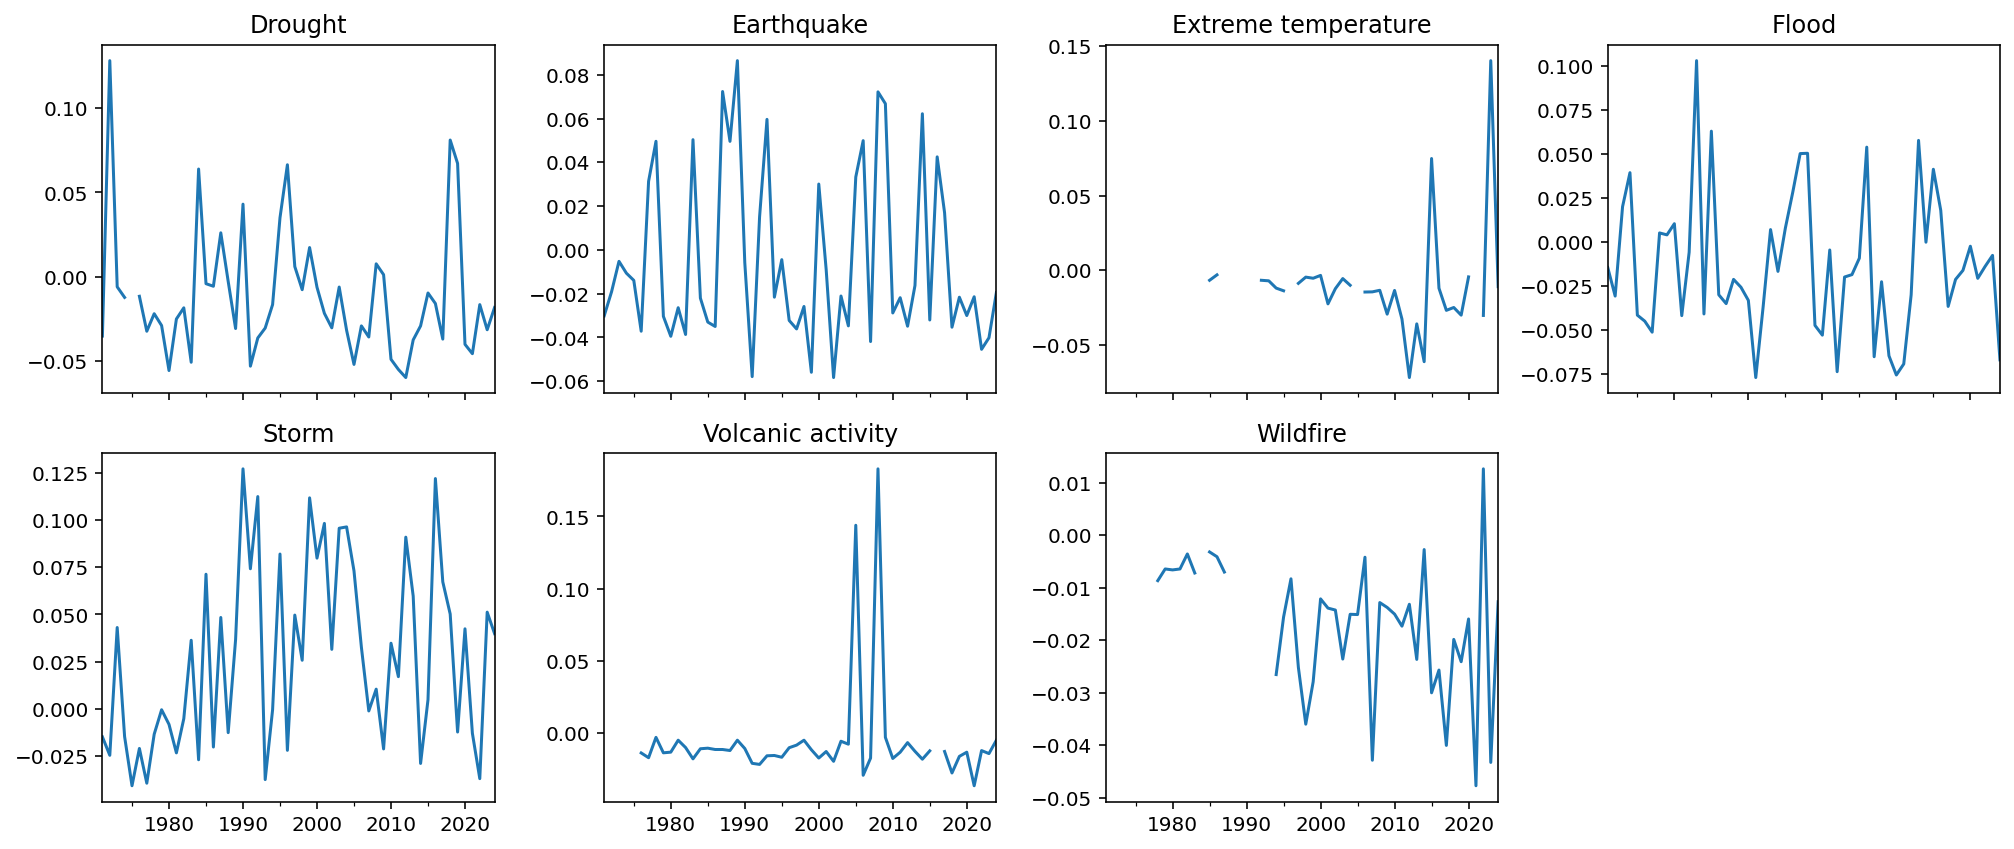

In [18]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6), dpi=144, sharex=True)
for axis, disaster in zip_longest(fig.axes, disasters):
    if disaster is None:
        axis.set_visible(False)
        continue
    corr_df[disaster].plot(ax=axis)
    axis.set_title(disaster)
fig.tight_layout()
plt.show()

## Rolling 10-year average

In [19]:
corr_df = pd.DataFrame(np.nan, columns=df_prob.columns, index=years[10:])
for disaster in disasters:
    merged_df = (connected_world.join(df_prob.unstack(1).fillna(0)[disaster])
                     .loc[:, years]
                     .T)
    for start, stop in zip(years[:-10], years[10:]):
        with warnings.catch_warnings(action='ignore'):
            mi = Moran(merged_df.loc[start:stop].mean(), w)
            corr_df.loc[start, disaster] = mi.I

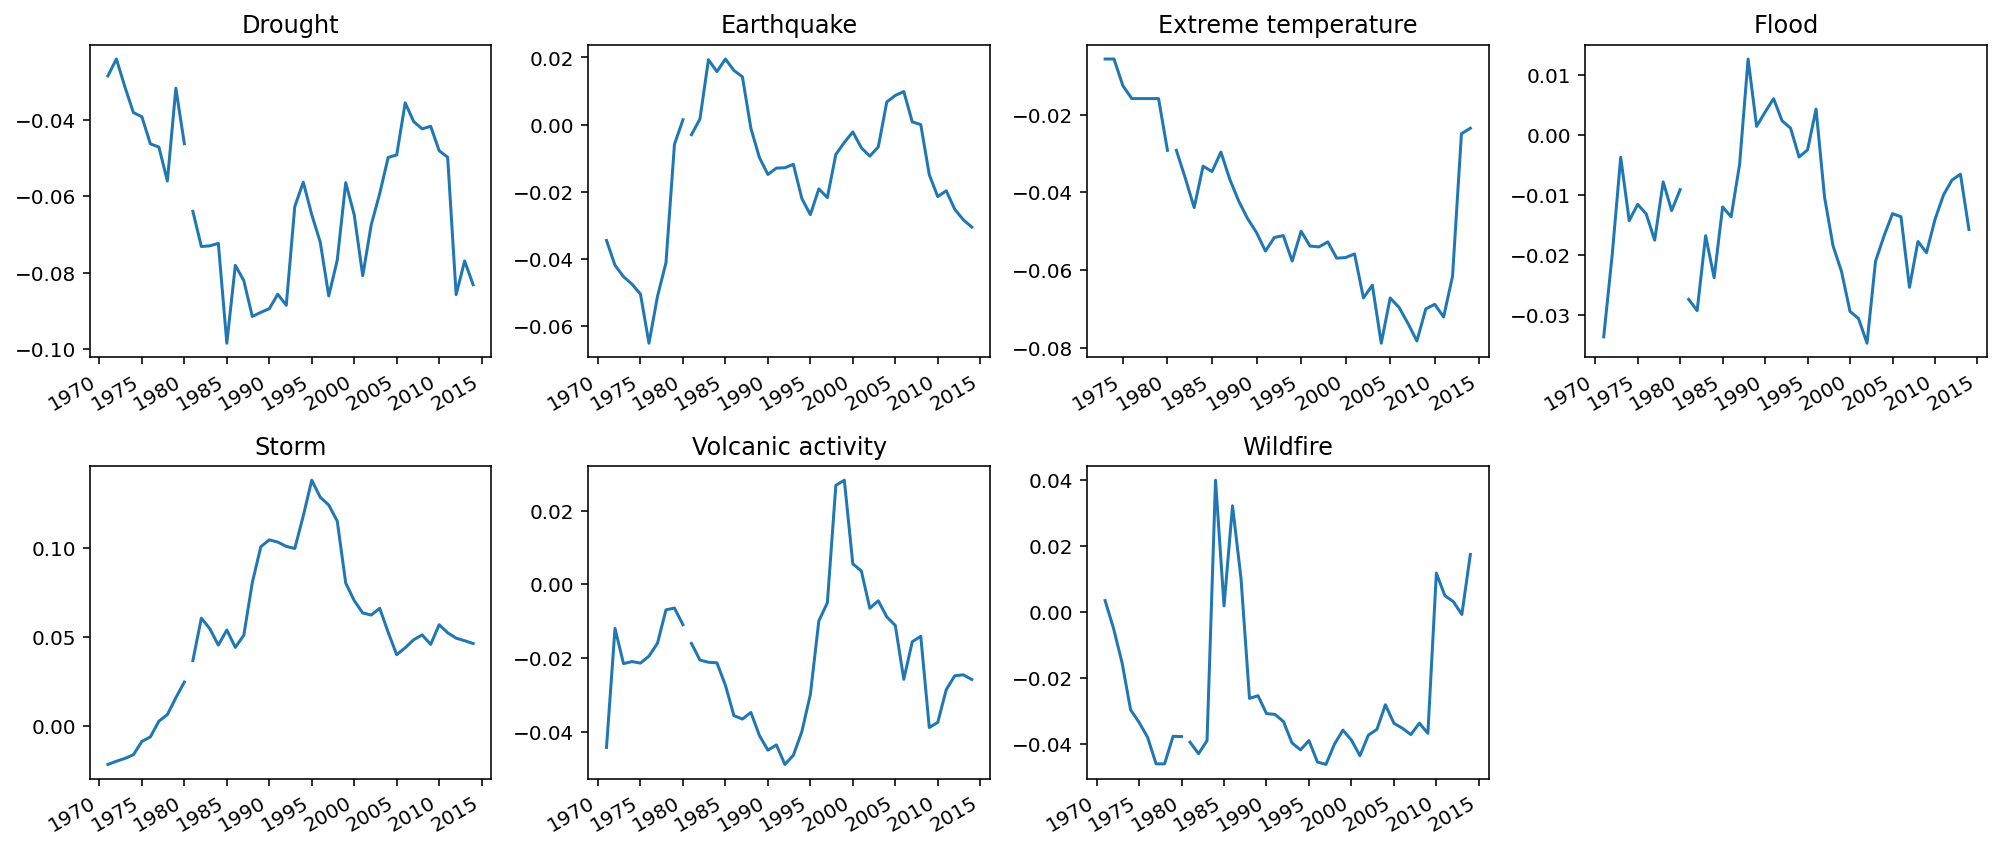

In [20]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6), dpi=144)
for axis, disaster in zip_longest(fig.axes, disasters):
    if disaster is None:
        axis.set_visible(False)
        continue
    corr_df[disaster].plot(ax=axis)
    axis.set_title(disaster)
fig.tight_layout()
plt.show()

# Variograms

In [21]:
import skgstat as skg

In [22]:
centroids = (world.geometry
                 .to_crs('EPSG:3857')
                 .centroid
                 .apply(lambda x: pd.Series({'x':x.x, 'y':x.y}))
                 .mul(1e-3)) # convert meters to km

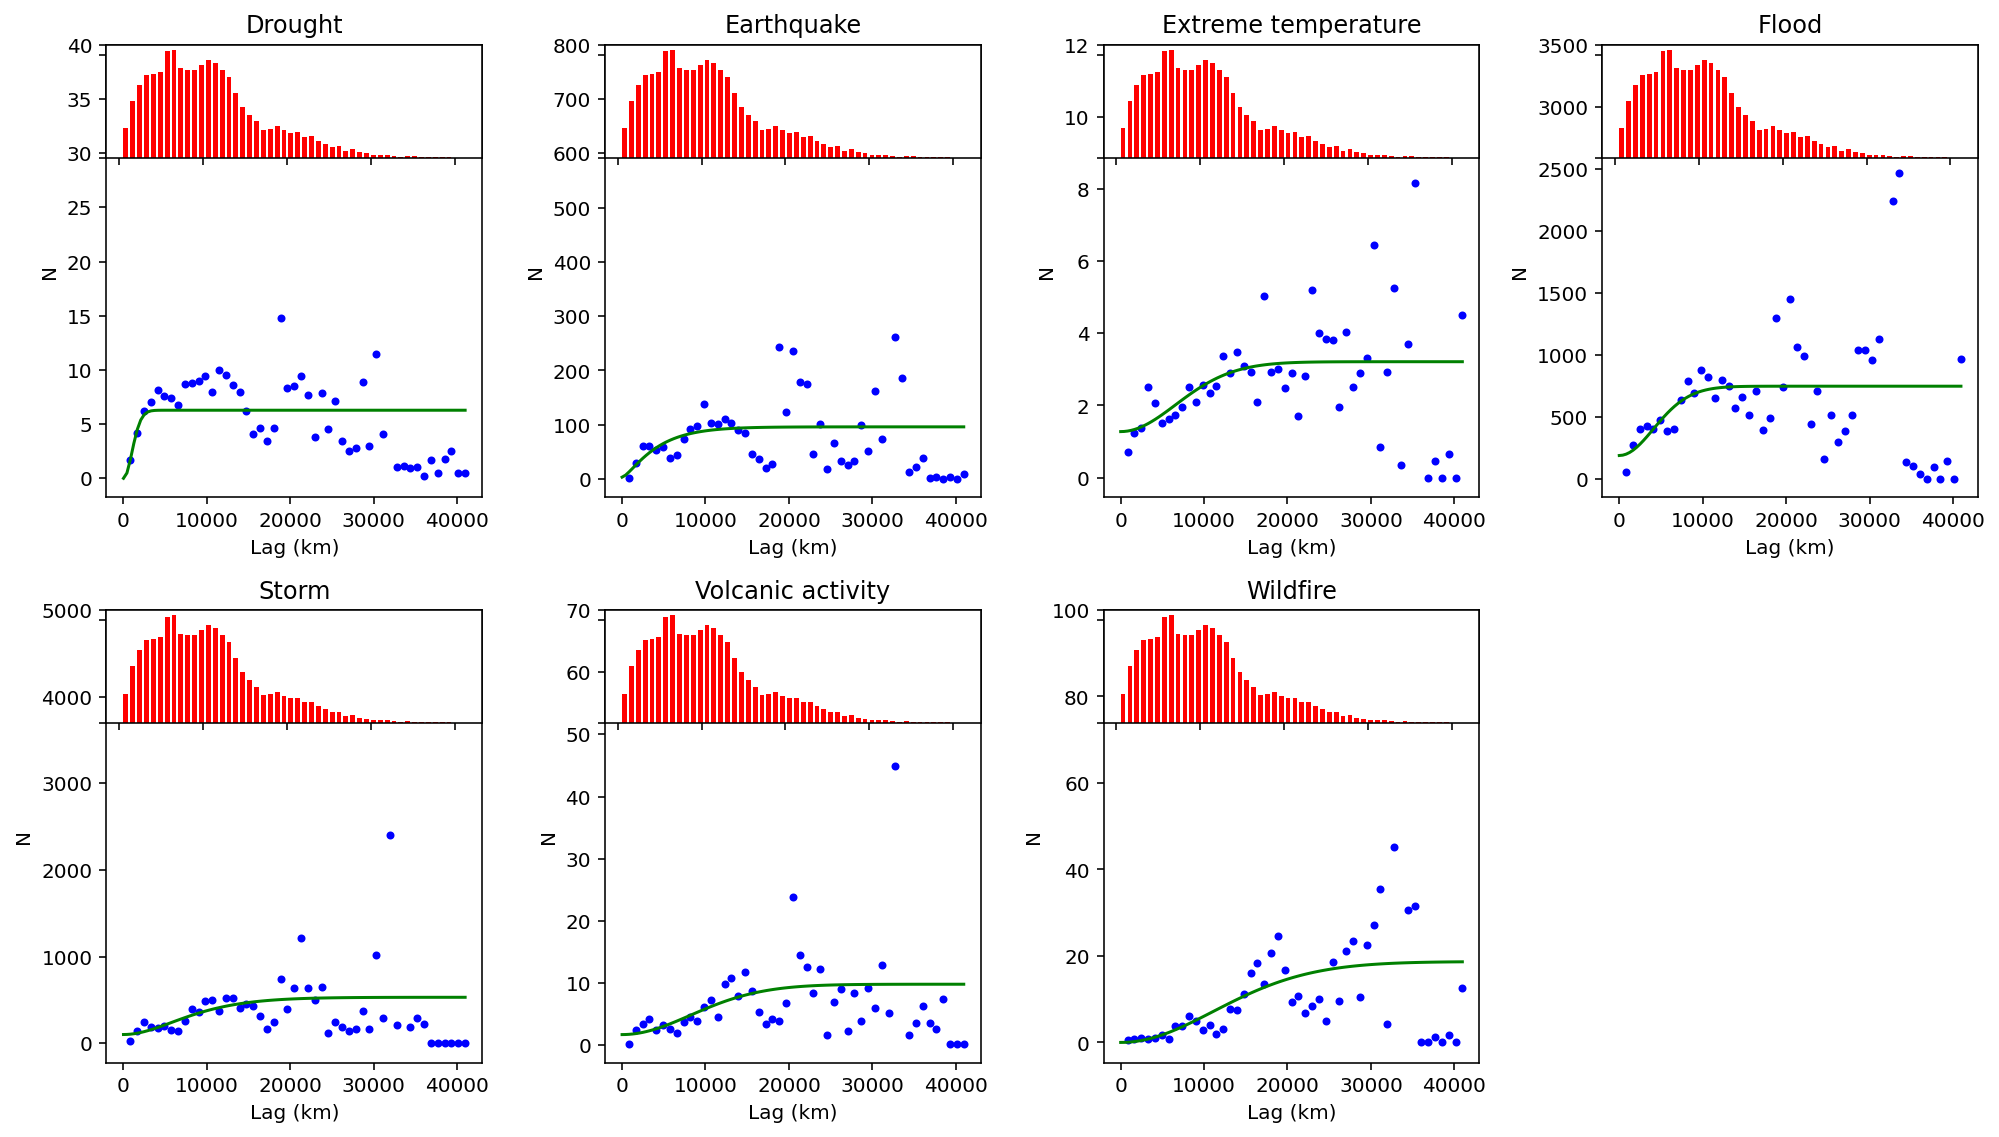

In [23]:
fig, ax = plt.subplots(2, 4, figsize=(14, 8), dpi=144)
for axis, disaster in zip_longest(fig.axes, disasters):
    if disaster is None:
        axis.set_visible(False)
        continue
    
    merged_df = (world.join(df_prob.unstack(1).fillna(0)[disaster])
                     .loc[:, years[-25:]]
                     .sum(axis=1))
    V = skg.Variogram(coordinates=centroids,
                      values=merged_df,
                      estimator='matheron',
                      dist_func='euclidean',
                      model='matern',
                      n_lags=50,
                      use_nugget=True)
    hist_ax = axis.inset_axes(bounds=[0, 0.75, 1.0, 0.25])
    V.plot(axes=[axis, hist_ax], show=False, grid=False)
    ticks = [x for x in hist_ax.xaxis.get_majorticklocs()]
    hist_ax.set_yticklabels([])
    hist_ax.set_xticklabels([])
    
    axis.set(title=disaster, xlabel = 'Lag (km)')
    axis.tick_params(axis='x', labelbottom=True)

    
fig.tight_layout()
plt.show()

# Models

In [24]:
#Defining the random seed for sampling
RANDOM_SEED = 8926
rng = np.random.default_rng(RANDOM_SEED)

In [25]:
#Scaling factor function
def scaling_factor_sp(A):
    """Compute the scaling factor from an adjacency matrix.
    This function uses sparse matrix computations and is most
    efficient on sparse adjacency matrices. Used in the BYM2 model.
    The scaling factor is a measure of the variance in the number of
    edges across nodes in a connected graph.
    Only works for fully connected graphs. The argument for scaling
    factors is developed by Andrea Riebler, Sigrunn H. Sørbye,
    Daniel Simpson, Havard Rue in "An intuitive Bayesian spatial
    model for disease mapping that accounts for scaling"
    https://arxiv.org/abs/1601.01180"""

    # Computes the precision matrix in sparse format
    # from an adjacency matrix.

    num_neighbors = A.sum(axis=1)
    A = sparse.csc_matrix(A)
    D = sparse.diags(num_neighbors, format="csc")
    Q = D - A

    # add a small jitter along the diagonal

    Q_perturbed = Q + sparse.diags(np.ones(Q.shape[0])) * max(Q.diagonal()) * np.sqrt(
        np.finfo(np.float64).eps
    )

    # Compute a version of the pseudo-inverse

    n = Q_perturbed.shape[0]
    b = sparse.identity(n, format="csc")
    Sigma = spsolve(Q_perturbed, b)
    A = np.ones(n)
    W = Sigma @ A.T
    Q_inv = Sigma - np.outer(W * solve(A @ W, np.ones(1)), W.T)

    # Compute the geometric mean of the diagonal on a
    # precision matrix.

    return np.exp(np.sum(np.log(np.diag(Q_inv))) / n)

In [26]:
#Defining the scaling factor
scaling_factor = scaling_factor_sp(A)
scaling_factor

1.0780858792524022

In [27]:
# Adjusting the shapes of coords and dara
df_prob = df_prob.drop(["ASM", "CYP", "EGY", "PLW", "PRI", "SXM"])

In [28]:
#Defining coords
iso_idx, iso = pd.factorize(df_prob.reset_index()['ISO'])
coords = {"iso": iso}

## Spatial only

### Drought

First, we sum over time to work only with space dimension

In [29]:
df_prob_space_drought = df_prob.pivot_table(values= ['Drought'] , index = "ISO" , aggfunc= "sum" )

In [30]:
with pm.Model(coords=coords) as BYM_model:
    # intercept
    beta0 = pm.Normal("beta0", mu =0, sigma = 1)

    # independent random effect
    theta = pm.Normal("theta", mu = 0, sigma = 1, dims="iso")

    # spatially structured random effect
    phi = pm.ICAR("phi", W= A.todense())

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1)
    
    # the mixing rate is rho
    rho = pm.Beta("rho", 0.5, 0.5)

    # the bym component - it mixes a spatial and a random effect
    mixture = pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi

    # exponential link function to ensure
    # predictions are positive
    mu = pt.exp(beta0 + sigma * mixture)

    y_i = pm.Poisson("y_i", mu, observed=df_prob_space_drought["Drought"])

In [31]:
#Sampling the model
with BYM_model:
    idata = pm.sample(draws = 500,chains = 8,  nuts_sampler="nutpie", random_seed=rng)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.05,383
,1500,0,0.05,127
,1500,0,0.05,255
,1500,0,0.05,127
,1500,0,0.05,127
,1500,0,0.05,127
,1500,0,0.05,63
,1500,0,0.05,511


In [32]:
az.summary(idata, var_names=["beta0", "sigma", "rho"] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.034,0.160,-0.347,0.246,0.003,0.002,2317.0,2808.0,1.00
sigma,1.586,0.146,1.321,1.855,0.004,0.003,1045.0,1441.0,1.00
rho,0.041,0.048,0.000,0.121,0.002,0.002,490.0,835.0,1.01


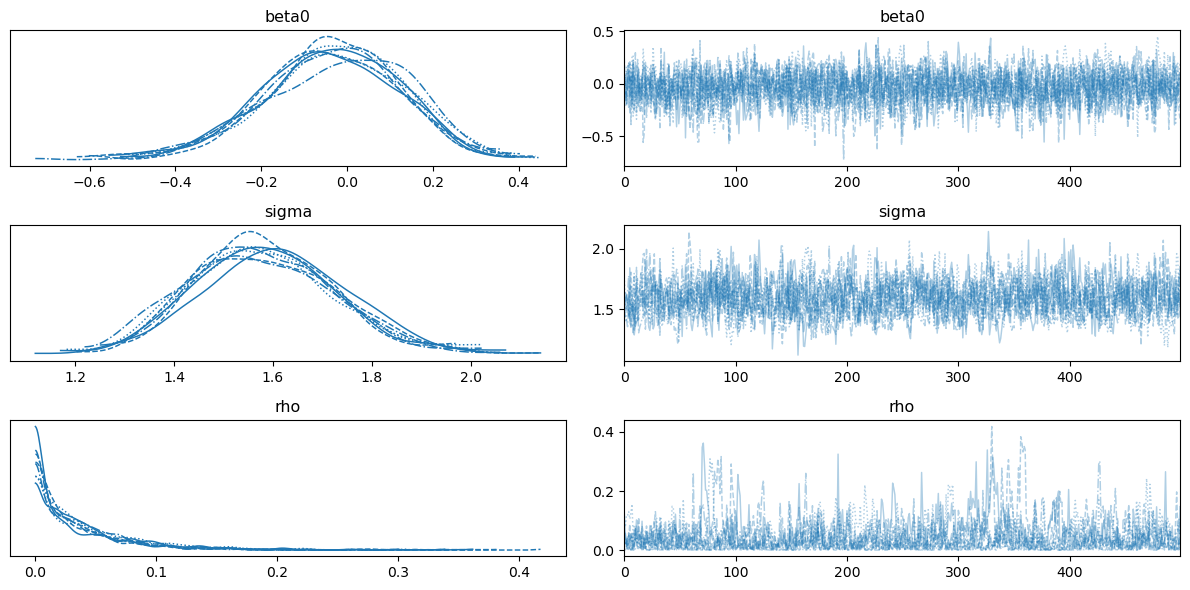

In [33]:
az.plot_trace(idata, var_names=["beta0", "sigma", "rho"])
plt.tight_layout();

In [34]:
phi_pred = idata.posterior.phi.mean(("chain", "draw")).values
beta0_pred = idata.posterior.beta0.mean(("chain", "draw")).values
sigma_pred = idata.posterior.sigma.mean(("chain", "draw")).values
y_predict = np.exp( beta0_pred + sigma_pred * (1 / scaling_factor) * phi_pred)

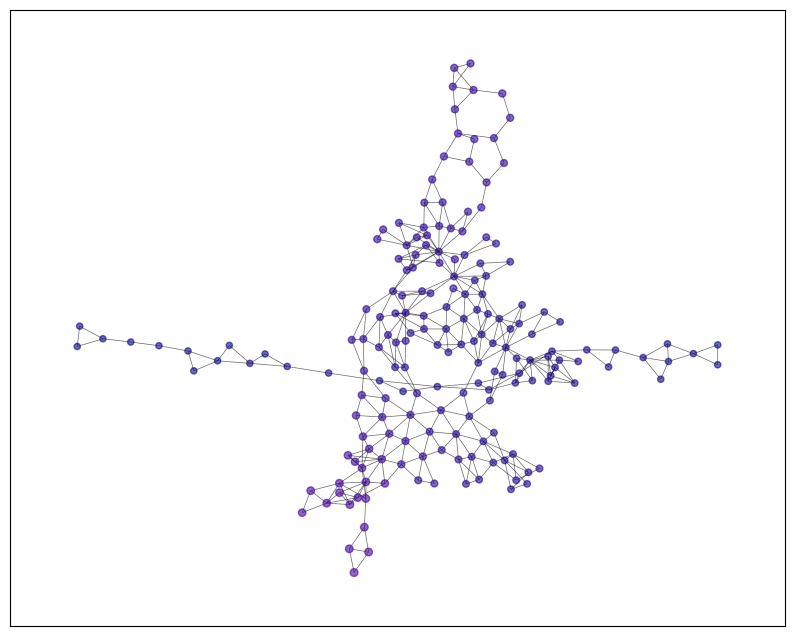

In [35]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G,
    pos=pos,
    node_color=y_predict,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_predict,
)

### Flood

First, we sum over time to work only with space dimension

In [36]:
df_prob_space_flood = df_prob.pivot_table(values= ['Flood'] , index = "ISO" , aggfunc= "sum" )

In [37]:
with pm.Model(coords=coords) as BYM_model:
    # intercept
    beta0 = pm.Normal("beta0", mu =0, sigma = 1)

    # independent random effect
    theta = pm.Normal("theta", mu = 0, sigma = 1, dims="iso")

    # spatially structured random effect
    phi = pm.ICAR("phi", W= A.todense())

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1)
    
    # the mixing rate is rho
    rho = pm.Beta("rho", 0.5, 0.5)

    # the bym component - it mixes a spatial and a random effect
    mixture = pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi

    # exponential link function to ensure
    # predictions are positive
    mu = pt.exp(beta0 + sigma * mixture)

    y_i = pm.Poisson("y_i", mu, observed=df_prob_space_flood["Flood"])

In [38]:
#Sampling the model
with BYM_model:
    idata = pm.sample(draws = 500,chains = 8,  nuts_sampler="nutpie", random_seed=rng)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.05,511
,1500,0,0.05,127
,1500,0,0.05,255
,1500,0,0.05,767
,1500,0,0.05,767
,1500,0,0.05,255
,1500,0,0.05,191
,1500,0,0.05,63


In [39]:
az.summary(idata, var_names=["beta0", "sigma", "rho"] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,1.973,0.127,1.729,2.206,0.003,0.002,2179.0,2831.0,1.00
sigma,1.634,0.111,1.439,1.853,0.003,0.002,1034.0,1822.0,1.01
rho,0.041,0.048,0.000,0.130,0.003,0.002,296.0,343.0,1.03


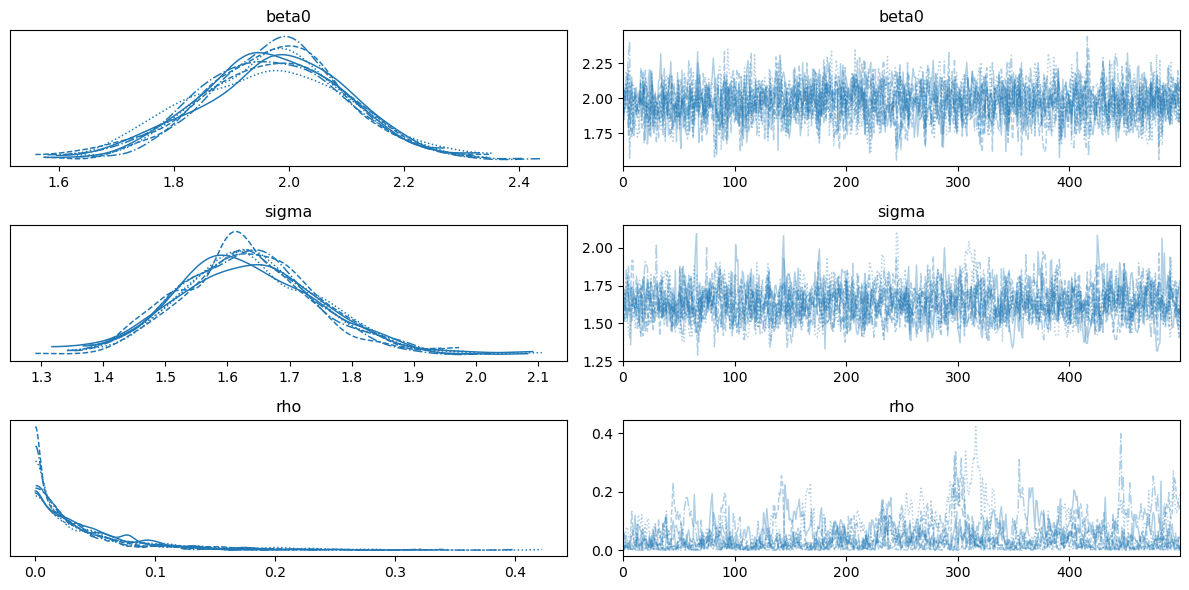

In [40]:
az.plot_trace(idata, var_names=["beta0", "sigma", "rho"])
plt.tight_layout();

In [41]:
phi_pred = idata.posterior.phi.mean(("chain", "draw")).values
beta0_pred = idata.posterior.beta0.mean(("chain", "draw")).values
sigma_pred = idata.posterior.sigma.mean(("chain", "draw")).values
y_predict = np.exp( beta0_pred + sigma_pred * (1 / scaling_factor) * phi_pred)

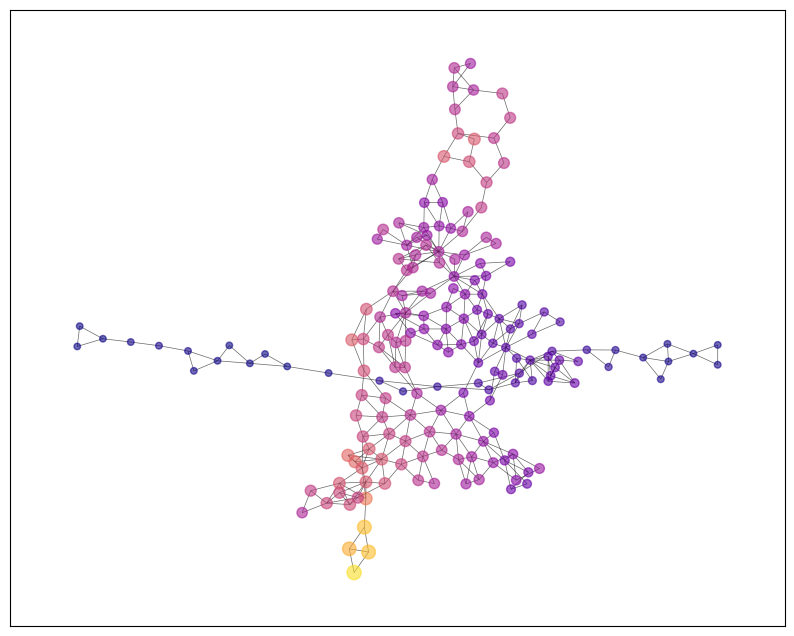

In [42]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G,
    pos=pos,
    node_color=y_predict,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_predict,
)

### Storm                  

First, we sum over time to work only with space dimension

In [43]:
df_prob_space_storm = df_prob.pivot_table(values= ['Storm'] , index = "ISO" , aggfunc= "sum" )

In [44]:
with pm.Model(coords=coords) as BYM_model:
    # intercept
    beta0 = pm.Normal("beta0", mu =0, sigma = 1)

    # independent random effect
    theta = pm.Normal("theta", mu = 0, sigma = 1, dims="iso")

    # spatially structured random effect
    phi = pm.ICAR("phi", W= A.todense())

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1)
    
    # the mixing rate is rho
    rho = pm.Beta("rho", 0.5, 0.5)

    # the bym component - it mixes a spatial and a random effect
    mixture = pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi

    # exponential link function to ensure
    # predictions are positive
    mu = pt.exp(beta0 + sigma * mixture)

    y_i = pm.Poisson("y_i", mu, observed= df_prob_space_storm["Storm"])

In [45]:
df_prob_space_storm.shape

(184, 1)

In [46]:
#Sampling the model
with BYM_model:
    idata = pm.sample(draws = 500,chains = 8,  nuts_sampler="nutpie", random_seed=rng)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.05,383
,1500,0,0.05,511
,1500,0,0.05,1023
,1500,0,0.05,127
,1500,0,0.05,511
,1500,0,0.05,255
,1500,0,0.05,383
,1500,0,0.05,383


In [47]:
az.summary(idata, var_names=["beta0", "sigma", "rho"] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.884,0.135,0.653,1.160,0.002,0.002,3174.0,2784.0,1.00
sigma,1.598,0.110,1.396,1.803,0.003,0.002,1357.0,1898.0,1.00
rho,0.032,0.035,0.000,0.095,0.001,0.001,968.0,1181.0,1.01


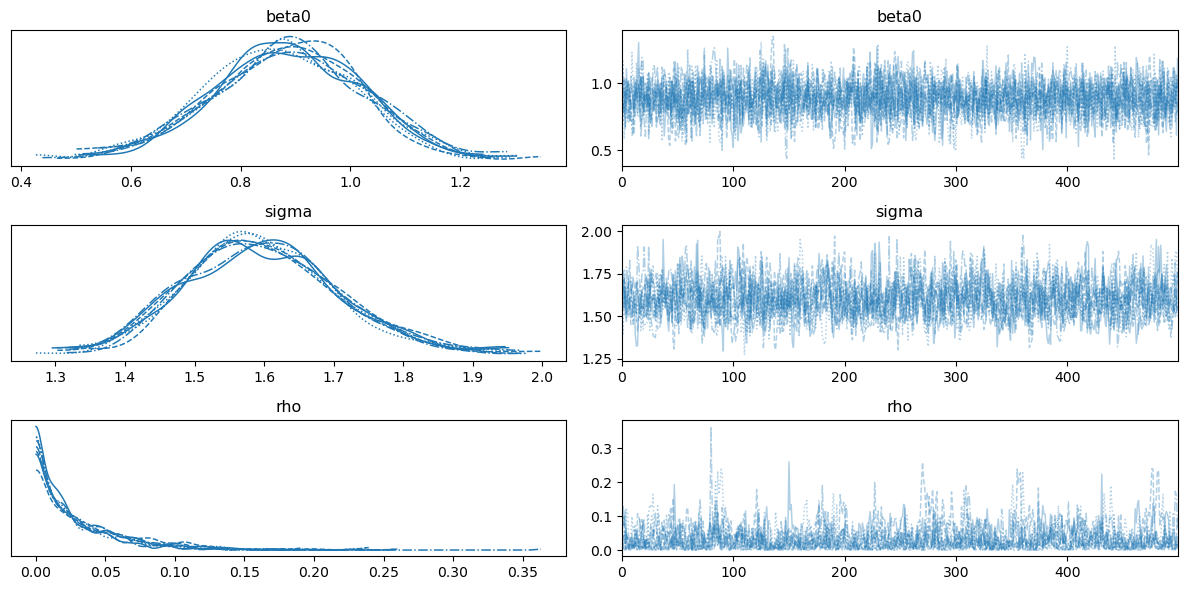

In [48]:
az.plot_trace(idata, var_names=["beta0", "sigma", "rho"])
plt.tight_layout();

In [49]:
phi_pred = idata.posterior.phi.mean(("chain", "draw")).values
beta0_pred = idata.posterior.beta0.mean(("chain", "draw")).values
sigma_pred = idata.posterior.sigma.mean(("chain", "draw")).values
y_predict = np.exp( beta0_pred + sigma_pred * (1 / scaling_factor) * phi_pred)

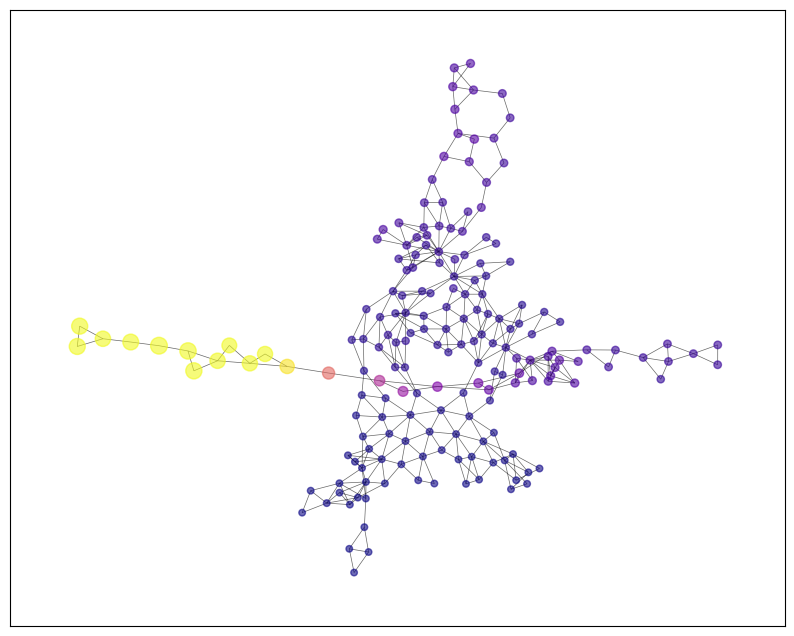

In [50]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G,
    pos=pos,
    node_color=y_predict,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_predict,
)

## Second version

In [51]:
#Re-load the data frame with region and Subregion
df_prob = data["df_prob_filtered_adjusted"].drop(["ASM", "CYP", "EGY", "PLW", "PRI", "SXM"])

In [52]:
#Defining coords
iso_idx, iso = pd.factorize(df_prob.reset_index()['ISO'])
region_idx, region = pd.factorize(df_prob.reset_index()['Region'])
subregion_idx, subregion = pd.factorize(df_prob.reset_index()['Subregion'])

coords = coords = {"iso": iso, "region": region, "subregion": subregion}

### Drought

First, we sum over time to work only with space dimension

In [53]:
df_prob_space_drought_second = df_prob.pivot_table(values= ['Drought'] , index = ["ISO", "Region", "Subregion"] , aggfunc= "sum" )

In [54]:
with pm.Model(coords=coords) as BYM_model:
    # intercept 1
    beta0 = pm.Normal("beta0", mu =0, sigma = 1)

    # intercept 2
    beta1 = pm.Normal("beta1", mu =0, sigma = 1)

    # intercept
    beta2 = pm.Normal("beta2", mu =0, sigma = 1)

    # independent random effect
    theta = pm.Normal("theta", mu = 0, sigma = 1, dims="iso")

    # spatially structured random effect
    phi = pm.ICAR("phi", W= A.todense())

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1)
    
    # the mixing rate is rho
    rho = pm.Beta("rho", 0.5, 0.5)

    # the bym component - it mixes a spatial and a random effect
    mixture = pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi

    # exponential link function to ensure
    # predictions are positive
    mu = pt.exp(beta0[iso_idx] + beta1[region_idx] + beta2[subregion_idx] + sigma * mixture)

    y_i = pm.Poisson("y_i", mu, observed=df_prob_space_drought_second["Drought"])

IndexError: too many indices for array

In [ ]:
#Sampling the model
with BYM_model:
    idata = pm.sample(draws = 500,chains = 8,  nuts_sampler="nutpie", random_seed=rng)

In [ ]:
az.summary(idata, var_names=["beta0", "sigma", "rho"] )

In [ ]:
az.plot_trace(idata, var_names=["beta0", "sigma", "rho"])
plt.tight_layout();

In [ ]:
phi_pred = idata.posterior.phi.mean(("chain", "draw")).values
beta0_pred = idata.posterior.beta0.mean(("chain", "draw")).values
sigma_pred = idata.posterior.sigma.mean(("chain", "draw")).values
y_predict = np.exp( beta0_pred + sigma_pred * (1 / scaling_factor) * phi_pred)

In [ ]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G,
    pos=pos,
    node_color=y_predict,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_predict,
)